# Loading Libraries

In [11]:
import pickle
import joblib
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from keras.models import Model
from prophet import Prophet
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Preprocessing all 3 datasets of all 3 sectors

### Managing seasonal and cyclic effects

In [12]:
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

### Finance Sector

In [13]:
finance_df = pd.read_csv("./Dataset/Monthly.csv")
finance_df['Date'] = pd.to_datetime(finance_df['Date'])
finance_df.drop_duplicates(inplace=True)
finance_df.fillna(method='ffill', inplace=True)
finance_df['close'] = manage_seasonal_cyclic(finance_df['close'])


### Energy Sector

In [14]:
energy_df = pd.read_csv("./Dataset/Hourly.csv")
energy_df['Datetime'] = pd.to_datetime(energy_df['Datetime'])
energy_df.drop_duplicates(inplace=True)
energy_df.fillna(method='ffill', inplace=True)
energy_df['AEP_MW'] = manage_seasonal_cyclic(energy_df['AEP_MW'])

### Environmental Sector

In [15]:
environment_df = pd.read_csv("./Dataset/Daily.csv")
environment_df['date'] = pd.to_datetime(environment_df['date'])
environment_df.drop_duplicates(inplace=True)
environment_df.fillna(method='ffill', inplace=True)
environment_df['value'] = manage_seasonal_cyclic(environment_df['value'])

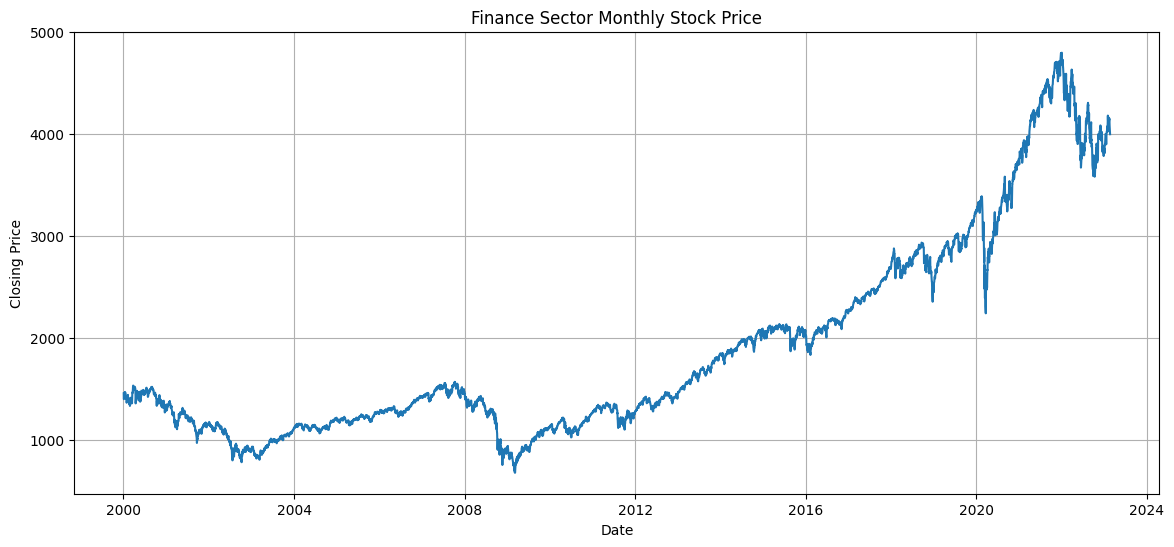

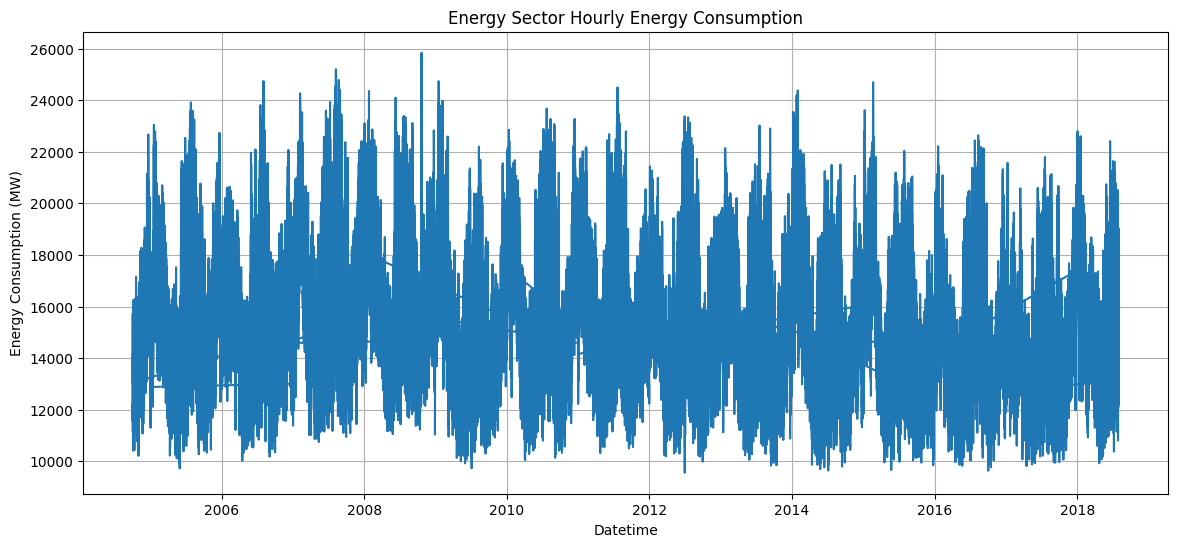

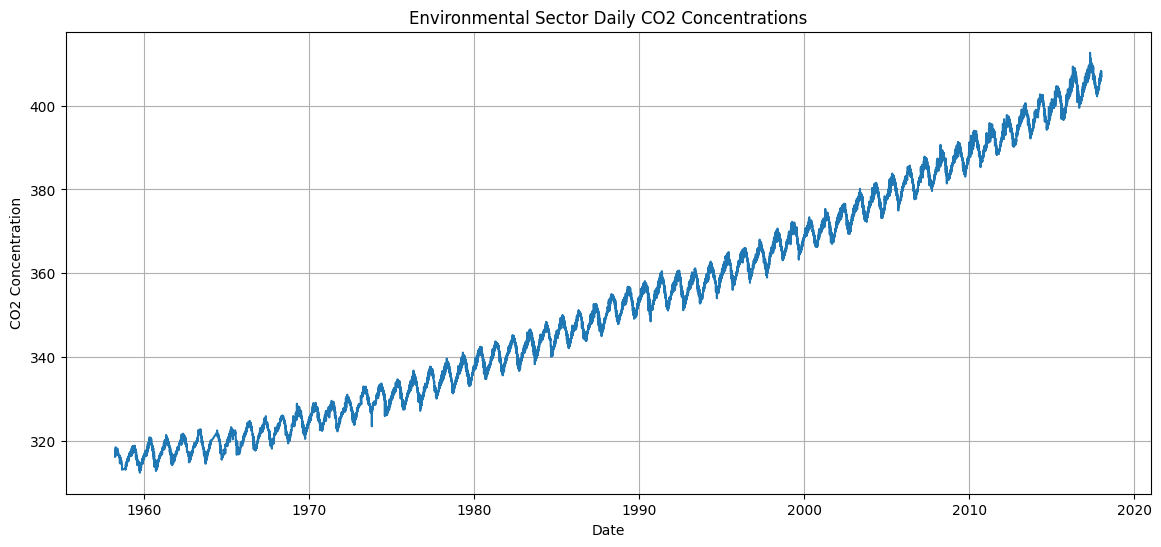

In [16]:
# Visualizing Finance sector
plt.figure(figsize=(14, 6))
plt.plot(finance_df['Date'], manage_seasonal_cyclic(finance_df['close']))
plt.title('Finance Sector Monthly Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# Visualizing Energy sector
plt.figure(figsize=(14, 6))
plt.plot(energy_df['Datetime'], manage_seasonal_cyclic(energy_df['AEP_MW']))
plt.title('Energy Sector Hourly Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.show()

# Visualizing Environmental sector
plt.figure(figsize=(14, 6))
plt.plot(environment_df['date'], manage_seasonal_cyclic(environment_df['value']))
plt.title('Environmental Sector Daily CO2 Concentrations')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()


In [17]:
finance_df, energy_df, environment_df

(           Date     open     high      low        close
 0    2000-01-03  1469.25  1478.00  1438.36  1453.793647
 1    2000-01-04  1455.22  1455.22  1397.43  1396.463452
 2    2000-01-05  1399.42  1413.27  1377.68  1400.027038
 3    2000-01-06  1402.11  1411.90  1392.10  1401.960166
 4    2000-01-07  1403.45  1441.47  1400.73  1439.999199
 ...         ...      ...      ...      ...          ...
 5816 2023-02-14  4126.70  4159.77  4095.01  4137.659977
 5817 2023-02-15  4119.50  4148.11  4103.98  4150.058111
 5818 2023-02-16  4114.75  4136.54  4089.49  4091.735815
 5819 2023-02-17  4077.73  4081.51  4047.95  4078.211219
 5820 2023-02-21  4052.35  4052.35  3995.19  3995.913647
 
 [5821 rows x 5 columns],
                   Datetime        AEP_MW
 0      2004-12-31 01:00:00  13318.628600
 1      2004-12-31 02:00:00  12762.652611
 2      2004-12-31 03:00:00  12556.374885
 3      2004-12-31 04:00:00  12562.181004
 4      2004-12-31 05:00:00  12770.517001
 ...                    ...         

# Model Development

### Arima

In [18]:
# Function to check the stationarity of the data
def check_stationarity(data):
    result = adfuller(data)
    if result[1] <= 0.05:
        return True, result[0]
    else:
        return False, result[0]

# Function to difference the data and determine the order of differencing (d)
def difference_data(data):
    d = 0
    stationary = False
    while not stationary:
        stationary, adf_statistic = check_stationarity(data)
        if not stationary:
            d += 1
            data = data.diff().dropna()  # Difference the data
    return data, d

# Stationarize finance sector data
finance_stationary, d_finance = difference_data(finance_df['close'])
print("Differencing order for finance sector data:", d_finance)

# Stationarize environmental sector data
environment_stationary, d_environment = difference_data(environment_df['value'])
print("Differencing order for environmental sector data:", d_environment)

Differencing order for finance sector data: 1
Differencing order for environmental sector data: 1


In [19]:
# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, order):
    model = ARIMA(train, order=order)
    try:
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
            #predictions.append(yhat)
            #history.append(test.iloc[t])
    except Exception as e:
        print(f'Error occurred: {e}')
        # continue
    error = mean_squared_error(test, predictions)
    return error

# Function to find the best ARIMA model parameters
def find_best_arima_parameters(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score}')
    return best_cfg

p_values = range(0,3)
q_values = range(0,3)
d_values = range(0,3)
# Define the datasets and search ranges
datasets = [(finance_df['close'], p_values, d_values, q_values),
            (energy_df['AEP_MW'], p_values, d_values, q_values),
            (environment_df['value'], p_values, d_values, q_values)]

for dataset in datasets:
    x=find_best_arima_parameters(dataset[0], dataset[1], dataset[2], dataset[3])
    print(x)

# Function to forecast with ARIMA model
def forecast_arima(model, train, forecast_steps):
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast

# Iterate over datasets to make forecasts and save them
for dataset in datasets:
    train_size = int(len(dataset[0]) * 0.8)
    train = dataset[0].iloc[:train_size]
    best_cfg = find_best_arima_parameters(dataset[0], dataset[1], dataset[2], dataset[3])
    forecast = forecast_arima(ARIMA(train, order=best_cfg), train, forecast_steps=10)
    filename = f"{dataset[0].name}_arima_forecast.pkl"  # Assuming dataset has a 'name' attribute
    with open(filename, 'wb') as f:
        pickle.dump(forecast, f)

ARIMA(0, 0, 0) MSE=4734172.746740047
ARIMA(0, 0, 1) MSE=4732732.40415959
ARIMA(0, 0, 2) MSE=4732054.717345694
ARIMA(0, 1, 0) MSE=1082329.8384704096
ARIMA(0, 1, 1) MSE=1084618.2583134372
ARIMA(0, 1, 2) MSE=1085080.453962731
ARIMA(0, 2, 0) MSE=176519185.76455954
ARIMA(0, 2, 1) MSE=400117.2087978279
ARIMA(0, 2, 2) MSE=371916.32016217045


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0) MSE=1500681.5925325488


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 1) MSE=1408302.8395769584


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 2) MSE=1367156.0713703092
ARIMA(1, 1, 0) MSE=1084355.8082599037
ARIMA(1, 1, 1) MSE=1086143.4411852588
ARIMA(1, 1, 2) MSE=1084769.3064204098
ARIMA(1, 2, 0) MSE=27030564.219416212
ARIMA(1, 2, 1) MSE=368502.9208951006
ARIMA(1, 2, 2) MSE=400569.5278533298


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 0) MSE=1418368.2794953694


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) MSE=1474564.9598895654


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 2) MSE=1361961.1021245334
ARIMA(2, 1, 0) MSE=1084879.4564360615
ARIMA(2, 1, 1) MSE=1084647.252210641
ARIMA(2, 1, 2) MSE=1084386.494242482
ARIMA(2, 2, 0) MSE=13951826.619142115
ARIMA(2, 2, 1) MSE=354834.5509666409
ARIMA(2, 2, 2) MSE=374892.08706609113
Best ARIMA(2, 2, 1) MSE=354834.5509666409
(2, 2, 1)
ARIMA(0, 0, 0) MSE=6942329.225106073


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE=6942211.4823779315


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE=6941927.151667097
ARIMA(0, 1, 0) MSE=18570081.852634273
ARIMA(0, 1, 1) MSE=18534131.521415412
ARIMA(0, 1, 2) MSE=18358626.58365559
ARIMA(0, 2, 0) MSE=3099036513256.662
ARIMA(0, 2, 1) MSE=5814851715863.051
ARIMA(0, 2, 2) MSE=6723905943371.021
ARIMA(1, 0, 0) MSE=6935145.132672936
ARIMA(1, 0, 1) MSE=6938672.915983853
ARIMA(1, 0, 2) MSE=6940540.844872833
ARIMA(1, 1, 0) MSE=20128264.014919713
ARIMA(1, 1, 1) MSE=20089159.235747658
ARIMA(1, 1, 2) MSE=19659690.736502975
ARIMA(1, 2, 0) MSE=5019222753175.959
ARIMA(1, 2, 1) MSE=112438311.61167188
ARIMA(1, 2, 2) MSE=32480654.4687742
ARIMA(2, 0, 0) MSE=6942673.655134791
ARIMA(2, 0, 1) MSE=6942807.232369813
ARIMA(2, 0, 2) MSE=6942765.159775652
ARIMA(2, 1, 0) MSE=20080147.521736313


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) MSE=20695189.22119638


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) MSE=6827875.475761824
ARIMA(2, 2, 0) MSE=5915956708646.632
ARIMA(2, 2, 1) MSE=32448035.24553387


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) MSE=32708255.90299571
Best ARIMA(2, 1, 2) MSE=6827875.475761824
(2, 1, 2)
ARIMA(0, 0, 0) MSE=2427.219899712278
ARIMA(0, 0, 1) MSE=2426.889060109343
ARIMA(0, 0, 2) MSE=2426.602164907176
ARIMA(0, 1, 0) MSE=144.25001473842363
ARIMA(0, 1, 1) MSE=143.5969105645171
ARIMA(0, 1, 2) MSE=143.01942823177956
ARIMA(0, 2, 0) MSE=42.76453519084149
ARIMA(0, 2, 1) MSE=12.244548667688566


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 2) MSE=12.151278200811966
ARIMA(1, 0, 0) MSE=860.748682962219
ARIMA(1, 0, 1) MSE=329.9321651297066


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 2) MSE=197.235476399423
ARIMA(1, 1, 0) MSE=144.27966378193824
ARIMA(1, 1, 1) MSE=143.08586485962718
ARIMA(1, 1, 2) MSE=143.0066374454988
ARIMA(1, 2, 0) MSE=14407.131984135267
ARIMA(1, 2, 1) MSE=9.946732405694835


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) MSE=10.976195007789162
ARIMA(2, 0, 0) MSE=503.6667212514176


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) MSE=14834.95642727072


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) MSE=1082.5405469682057
ARIMA(2, 1, 0) MSE=143.91056727687857
ARIMA(2, 1, 1) MSE=142.9797342132298
ARIMA(2, 1, 2) MSE=100.84796220305697
ARIMA(2, 2, 0) MSE=46196.40744376107
ARIMA(2, 2, 1) MSE=12.379594144077542
ARIMA(2, 2, 2) MSE=21449.605283565223
Best ARIMA(1, 2, 1) MSE=9.946732405694835
(1, 2, 1)
ARIMA(0, 0, 0) MSE=4734172.746740047
ARIMA(0, 0, 1) MSE=4732732.40415959
ARIMA(0, 0, 2) MSE=4732054.717345694
ARIMA(0, 1, 0) MSE=1082329.8384704096
ARIMA(0, 1, 1) MSE=1084618.2583134372
ARIMA(0, 1, 2) MSE=1085080.453962731
ARIMA(0, 2, 0) MSE=176519185.76455954
ARIMA(0, 2, 1) MSE=400117.2087978279
ARIMA(0, 2, 2) MSE=371916.32016217045


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0) MSE=1500681.5925325488


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 1) MSE=1408302.8395769584


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 2) MSE=1367156.0713703092
ARIMA(1, 1, 0) MSE=1084355.8082599037
ARIMA(1, 1, 1) MSE=1086143.4411852588
ARIMA(1, 1, 2) MSE=1084769.3064204098
ARIMA(1, 2, 0) MSE=27030564.219416212
ARIMA(1, 2, 1) MSE=368502.9208951006
ARIMA(1, 2, 2) MSE=400569.5278533298


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 0) MSE=1418368.2794953694


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) MSE=1474564.9598895654


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 2) MSE=1361961.1021245334
ARIMA(2, 1, 0) MSE=1084879.4564360615
ARIMA(2, 1, 1) MSE=1084647.252210641
ARIMA(2, 1, 2) MSE=1084386.494242482
ARIMA(2, 2, 0) MSE=13951826.619142115
ARIMA(2, 2, 1) MSE=354834.5509666409
ARIMA(2, 2, 2) MSE=374892.08706609113
Best ARIMA(2, 2, 1) MSE=354834.5509666409
ARIMA(0, 0, 0) MSE=6942329.225106073


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE=6942211.4823779315


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE=6941927.151667097
ARIMA(0, 1, 0) MSE=18570081.852634273
ARIMA(0, 1, 1) MSE=18534131.521415412
ARIMA(0, 1, 2) MSE=18358626.58365559
ARIMA(0, 2, 0) MSE=3099036513256.662
ARIMA(0, 2, 1) MSE=5814851715863.051
ARIMA(0, 2, 2) MSE=6723905943371.021
ARIMA(1, 0, 0) MSE=6935145.132672936
ARIMA(1, 0, 1) MSE=6938672.915983853
ARIMA(1, 0, 2) MSE=6940540.844872833
ARIMA(1, 1, 0) MSE=20128264.014919713
ARIMA(1, 1, 1) MSE=20089159.235747658
ARIMA(1, 1, 2) MSE=19659690.736502975
ARIMA(1, 2, 0) MSE=5019222753175.959
ARIMA(1, 2, 1) MSE=112438311.61167188
ARIMA(1, 2, 2) MSE=32480654.4687742
ARIMA(2, 0, 0) MSE=6942673.655134791
ARIMA(2, 0, 1) MSE=6942807.232369813
ARIMA(2, 0, 2) MSE=6942765.159775652
ARIMA(2, 1, 0) MSE=20080147.521736313


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) MSE=20695189.22119638


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) MSE=6827875.475761824
ARIMA(2, 2, 0) MSE=5915956708646.632
ARIMA(2, 2, 1) MSE=32448035.24553387


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) MSE=32708255.90299571
Best ARIMA(2, 1, 2) MSE=6827875.475761824


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 0) MSE=2427.219899712278
ARIMA(0, 0, 1) MSE=2426.889060109343
ARIMA(0, 0, 2) MSE=2426.602164907176
ARIMA(0, 1, 0) MSE=144.25001473842363
ARIMA(0, 1, 1) MSE=143.5969105645171
ARIMA(0, 1, 2) MSE=143.01942823177956
ARIMA(0, 2, 0) MSE=42.76453519084149
ARIMA(0, 2, 1) MSE=12.244548667688566


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 2) MSE=12.151278200811966
ARIMA(1, 0, 0) MSE=860.748682962219
ARIMA(1, 0, 1) MSE=329.9321651297066


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 2) MSE=197.235476399423
ARIMA(1, 1, 0) MSE=144.27966378193824
ARIMA(1, 1, 1) MSE=143.08586485962718
ARIMA(1, 1, 2) MSE=143.0066374454988
ARIMA(1, 2, 0) MSE=14407.131984135267
ARIMA(1, 2, 1) MSE=9.946732405694835


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) MSE=10.976195007789162
ARIMA(2, 0, 0) MSE=503.6667212514176


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) MSE=14834.95642727072


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) MSE=1082.5405469682057
ARIMA(2, 1, 0) MSE=143.91056727687857
ARIMA(2, 1, 1) MSE=142.9797342132298
ARIMA(2, 1, 2) MSE=100.84796220305697
ARIMA(2, 2, 0) MSE=46196.40744376107
ARIMA(2, 2, 1) MSE=12.379594144077542
ARIMA(2, 2, 2) MSE=21449.605283565223
Best ARIMA(1, 2, 1) MSE=9.946732405694835


In [20]:
# print(best_cfg_finance)
# print(best_cfg_energy)

### ANN

In [21]:
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_and_evaluate_ann(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ann_model = build_ann_model(X_train_scaled.shape[1])
    history = ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    loss, metric = ann_model.evaluate(X_test_scaled, y_test)
    
    return loss, metric

# For finance dataset
X_finance = finance_df.drop(columns=['Date', 'close'])
y_finance = finance_df['close']
X_train_finance, X_test_finance, y_train_finance, y_test_finance = train_test_split(X_finance, y_finance, test_size=0.2, random_state=42)

finance_loss, finance_metric = train_and_evaluate_ann(X_train_finance, y_train_finance, X_test_finance, y_test_finance)
print(f'Finance Dataset - Loss: {finance_loss}, Metric: {finance_metric}')

# For energy dataset
X_energy = energy_df.drop(columns=['Datetime'])
y_energy = energy_df['AEP_MW']
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(X_energy, y_energy, test_size=0.2, random_state=42)

energy_loss, energy_metric = train_and_evaluate_ann(X_train_energy, y_train_energy, X_test_energy, y_test_energy)
print(f'Energy Dataset - Loss: {energy_loss}, Metric: {energy_metric}')

# For environment dataset
X_environment = environment_df.drop(columns=['date'])
y_environment = environment_df['value']
X_train_environment, X_test_environment, y_train_environment, y_test_environment = train_test_split(X_environment, y_environment, test_size=0.2, random_state=42)

environment_loss, environment_metric = train_and_evaluate_ann(X_train_environment, y_train_environment, X_test_environment, y_test_environment)
print(f'Environment Dataset - Loss: {environment_loss}, Metric: {environment_metric}')



c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


37/37 [==============================] - 0s 2ms/step - loss: 298.9086 - mae: 10.5907
Finance Dataset - Loss: 298.9085693359375, Metric: 10.590717315673828


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


758/758 [==============================] - 2s 2ms/step - loss: 7.7020e-05 - mae: 0.0073
Energy Dataset - Loss: 7.702020229771733e-05, Metric: 0.007320696022361517


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


118/118 [==============================] - 0s 2ms/step - loss: 7.9982e-07 - mae: 8.5520e-04
Environment Dataset - Loss: 7.998234536898963e-07, Metric: 0.0008551996434107423


In [22]:
def train_and_evaluate_ann(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ann_model = build_ann_model(X_train_scaled.shape[1])
    history = ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = ann_model.predict(X_test_scaled)
    return ann_model, y_pred

finance_ann_model, finance_predictions = train_and_evaluate_ann(X_train_finance, y_train_finance, X_test_finance, y_test_finance)
energy_ann_model, energy_predictions = train_and_evaluate_ann(X_train_energy, y_train_energy, X_test_energy, y_test_energy)
environment_ann_model, environment_predictions = train_and_evaluate_ann(X_train_environment, y_train_environment, X_test_environment, y_test_environment)

# Save ANN models and predictions into .pkl files
with open('finance_ann_model.pkl', 'wb') as f:
    pickle.dump(finance_ann_model, f)
with open('finance_predictions_ann.pkl', 'wb') as f:
    pickle.dump(finance_predictions, f)

with open('energy_ann_model.pkl', 'wb') as f:
    pickle.dump(energy_ann_model, f)
with open('energy_predictions_ann.pkl', 'wb') as f:
    pickle.dump(energy_predictions, f)

with open('environment_ann_model.pkl', 'wb') as f:
    pickle.dump(environment_ann_model, f)
with open('environment_predictions_ann.pkl', 'wb') as f:
    pickle.dump(environment_predictions, f)

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


37/37 [==============================] - 0s 2ms/step


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


758/758 [==============================] - 1s 2ms/step


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


118/118 [==============================] - 0s 2ms/step


### SRIMA

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_data(data):
    d = 0
    stationary = False
    while not stationary:
        stationary, adf_statistic = check_stationarity(data)
        if not stationary:
            d += 1
            data = data.diff().dropna()  # Difference the data
    return data, d

# Function to difference the seasonal data and determine the order of seasonal differencing (D)
def difference_seasonal_data(data, m):
    D = 0
    seasonal_stationary = False
    while not seasonal_stationary:
        seasonal_stationary, _ = check_stationarity(data)
        if not seasonal_stationary:
            D += 1
            data = data.diff(m).dropna()  # Difference the data with a seasonal lag of m
    return data, D


Differencing order for finance sector data: 1


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


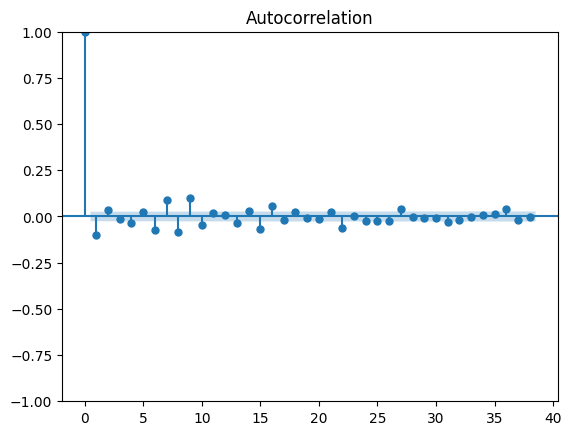

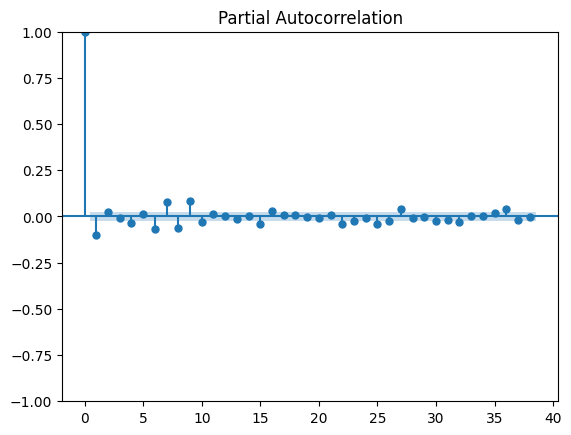

Differencing order for environmental sector data: 1


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


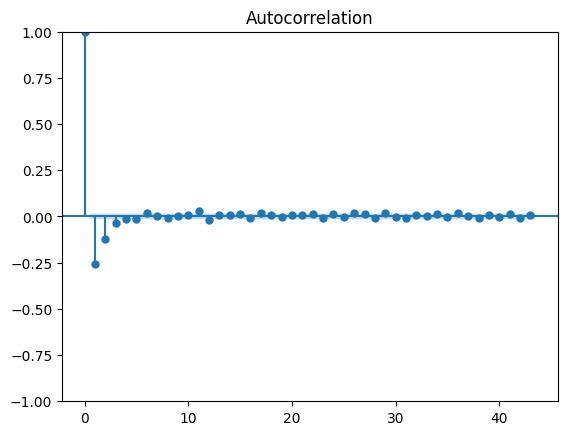

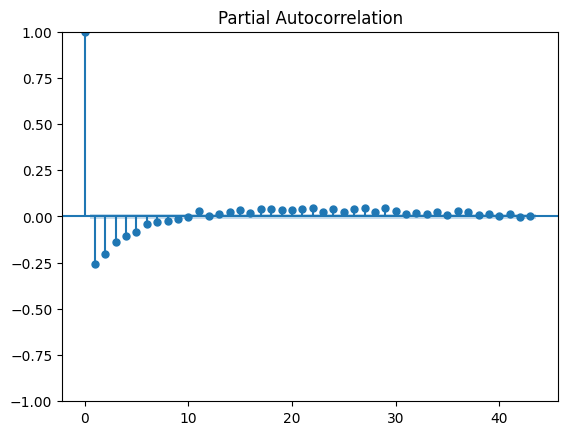

Differencing order for energy sector data: 0


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


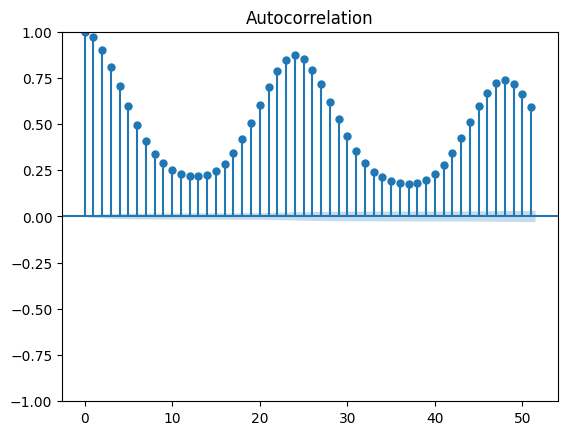

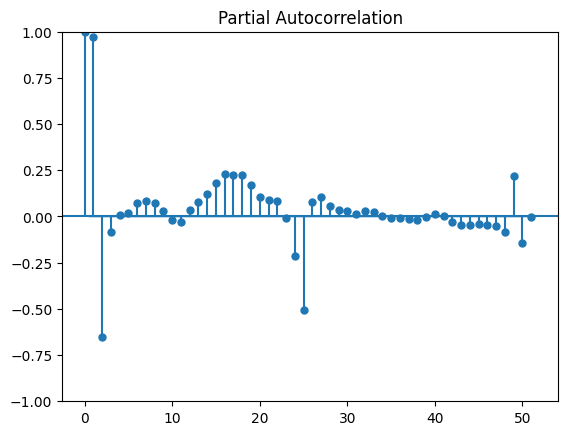

In [24]:
# Determine the order of differencing (d) for finance sector data
finance_diff, d_finance = difference_data(finance_df['close'])
print("Differencing order for finance sector data:", d_finance)

# Determine the order of seasonal differencing (D) for finance sector data
plot_acf(finance_diff)
plot_pacf(finance_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters

# Determine the order of differencing (d) for environmental sector data
environment_diff, d_environment = difference_data(environment_df['value'])
print("Differencing order for environmental sector data:", d_environment)

# Determine the order of seasonal differencing (D) for environmental sector data
plot_acf(environment_diff)
plot_pacf(environment_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters

# Determine the order of differencing (d) for energy sector data
energy_diff, d_energy = difference_data(energy_df['AEP_MW'])
print("Differencing order for energy sector data:", d_energy)

# Determine the order of seasonal differencing (D) for energy sector data
plot_acf(energy_diff)
plot_pacf(energy_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters


### Implementing Exponential Smoothing (ETS)

In [25]:
def apply_ets(df, column_name, seasonal=None, seasonal_periods=None):
    if seasonal_periods is None:
        raise ValueError("Please provide the seasonal_periods parameter.")
    df = df.reset_index(drop=True)  # Resetting the index
    ets_model = ExponentialSmoothing(df[column_name], seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    forecast = ets_model.forecast(steps=10)
    return forecast


finance_ets_forecast = apply_ets(finance_df, 'close', seasonal='add', seasonal_periods=12)  # 12 for monthly data
energy_ets_forecast = apply_ets(energy_df, 'AEP_MW', seasonal='add', seasonal_periods=24)  # 24 for hourly data
environment_ets_forecast = apply_ets(environment_df, 'value', seasonal='add', seasonal_periods=52)  # 52 for daily data

# Save ETS forecasts into .pkl files
with open('finance_ets_forecast.pkl', 'wb') as f:
    pickle.dump(finance_ets_forecast, f)
with open('energy_ets_forecast.pkl', 'wb') as f:
    pickle.dump(energy_ets_forecast, f)
with open('environment_ets_forecast.pkl', 'wb') as f:
    pickle.dump(environment_ets_forecast, f)


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [26]:
def apply_ets(df, column_name, seasonal=None, seasonal_periods=None):
    if seasonal_periods is None:
        raise ValueError("Please provide the seasonal_periods parameter.")
    df = df.reset_index(drop=True)  # Resetting the index
    ets_model = ExponentialSmoothing(df[column_name], seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    return ets_model

finance_ets_model = apply_ets(finance_df, 'close', seasonal='add', seasonal_periods=12)  # 12 for monthly data
energy_ets_model = apply_ets(energy_df, 'AEP_MW', seasonal='add', seasonal_periods=24)  # 24 for hourly data
environment_ets_model = apply_ets(environment_df, 'value', seasonal='add', seasonal_periods=52)  # 52 for daily data

def calculate_metrics(model, X, y):
    # Reset index if necessary
    X = X.reset_index(drop=True)
    # Make predictions
    y_pred = model.predict(start=X.index[0], end=X.index[-1])
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    return mse, mae, rmse, r2


# Finance dataset
mse_finance, mae_finance, rmse_finance, r2_finance = calculate_metrics(finance_ets_model, X_finance, y_finance)
print("Finance dataset:")
print("MSE:", mse_finance)
print("MAE:", mae_finance)
print("RMSE:", rmse_finance)
print("R2:", r2_finance)

# Energy dataset
mse_energy, mae_energy, rmse_energy, r2_energy = calculate_metrics(energy_ets_model, X_energy, y_energy)
print("Energy dataset:")
print("MSE:", mse_energy)
print("MAE:", mae_energy)
print("RMSE:", rmse_energy)
print("R2:", r2_energy)

# Environment dataset
mse_environment, mae_environment, rmse_environment, r2_environment = calculate_metrics(environment_ets_model, X_environment, y_environment)
print("Environment dataset:")
print("MSE:", mse_environment)
print("MAE:", mae_environment)
print("RMSE:", rmse_environment)
print("R2:", r2_environment)

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finance dataset:
MSE: 618.7857534046295
MAE: 15.108209737056628
RMSE: 24.875404587757554
R2: 0.9993510824712432
Energy dataset:
MSE: 213363.8608457475
MAE: 304.0287331127811
RMSE: 461.91326117112885
R2: 0.9681692367558731
Environment dataset:
MSE: 0.2671893648350186
MAE: 0.3578717721941742
RMSE: 0.5169036320582576
R2: 0.9996109557443623


### Implementing Prophet

20:14:56 - cmdstanpy - INFO - Chain [1] start processing
20:15:00 - cmdstanpy - INFO - Chain [1] done processing


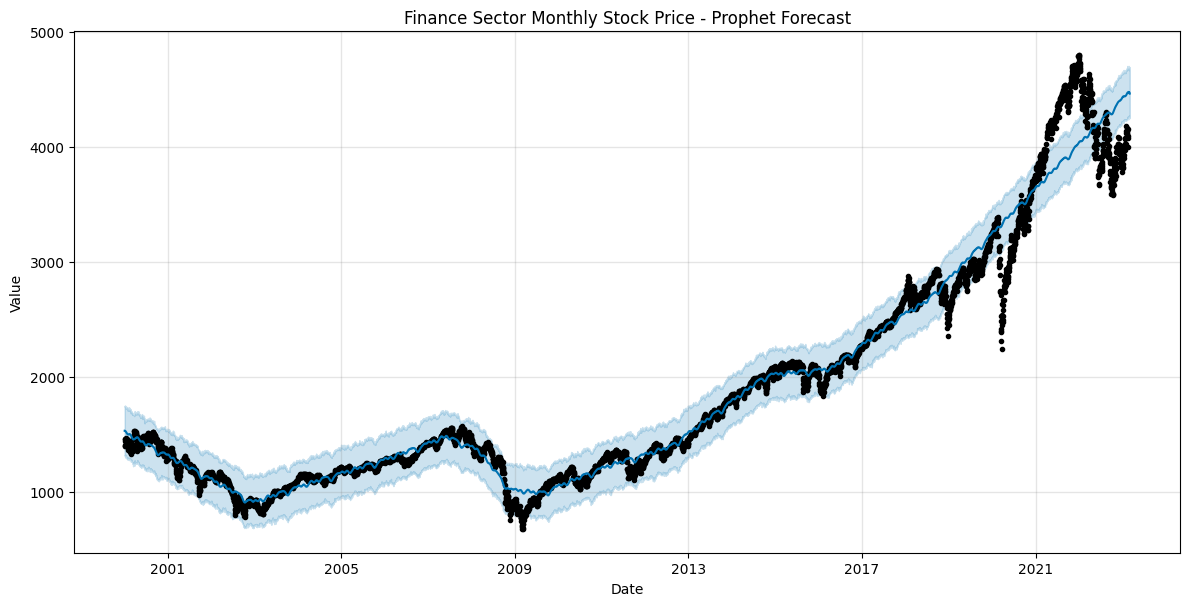

20:15:08 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing


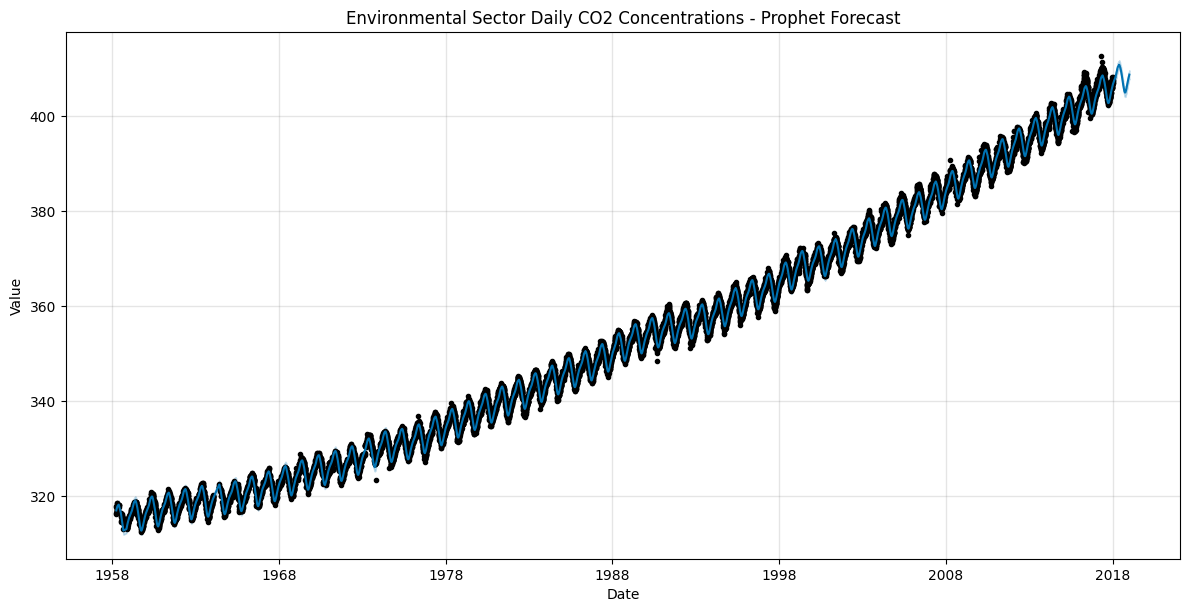

20:16:13 - cmdstanpy - INFO - Chain [1] start processing
20:18:57 - cmdstanpy - INFO - Chain [1] done processing


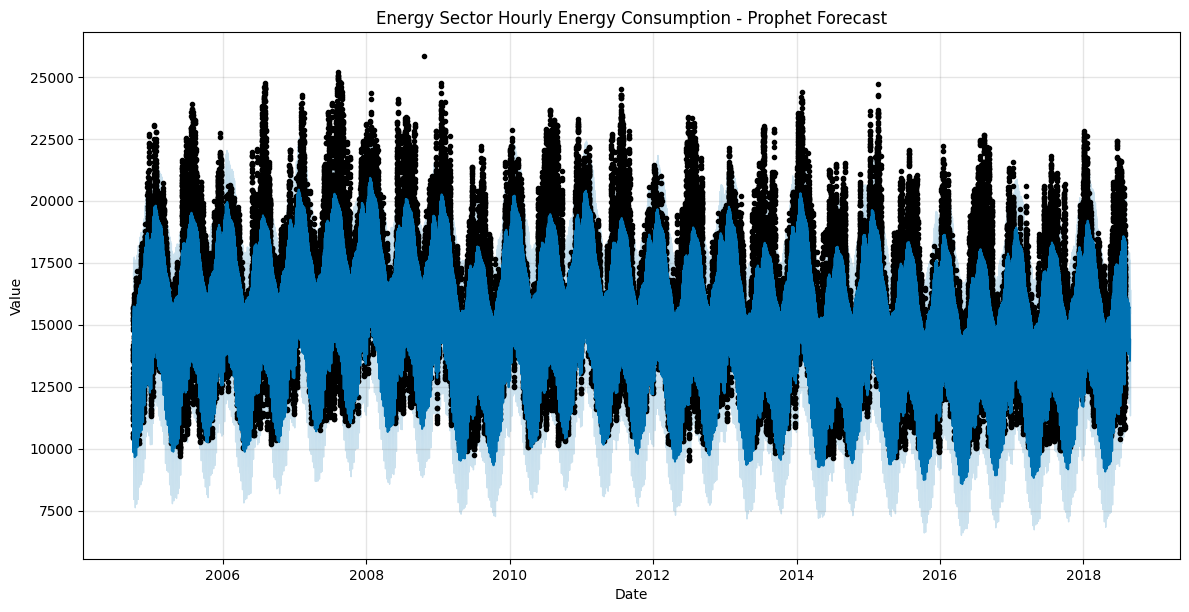

In [27]:
# Function to apply Prophet model
def apply_prophet(df, column, title,d, p):
    data = df.rename(columns={d: 'ds', column: 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(data)
    future = model.make_future_dataframe(periods=p)
    forecast = model.predict(future)
    model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(12, 6))
    plt.title(f'{title} - Prophet Forecast')
    plt.show()

# Apply Prophet model to each dataset
apply_prophet(finance_df, 'close', 'Finance Sector Monthly Stock Price' ,"Date", 12)
apply_prophet(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations','date',365)
apply_prophet(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption','Datetime', 24)

In [28]:
# Function to apply Prophet model and return the forecast DataFrame
def apply_prophet(df, column, title, d, p):
    data = df.rename(columns={d: 'ds', column: 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(data)
    future = model.make_future_dataframe(periods=p)
    forecast = model.predict(future)
    return forecast

# Apply Prophet model to each dataset and retrieve forecasts
finance_prophet_forecast = apply_prophet(finance_df, 'close', 'Finance Sector Monthly Stock Price', "Date", 12)
environment_prophet_forecast = apply_prophet(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations', 'date', 365)
energy_prophet_forecast = apply_prophet(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption', 'Datetime', 24)

# Save Prophet forecasts into .pkl files
with open('finance_prophet_forecast.pkl', 'wb') as f:
    pickle.dump(finance_prophet_forecast, f)
with open('environment_prophet_forecast.pkl', 'wb') as f:
    pickle.dump(environment_prophet_forecast, f)
with open('energy_prophet_forecast.pkl', 'wb') as f:
    pickle.dump(energy_prophet_forecast, f)

20:20:10 - cmdstanpy - INFO - Chain [1] start processing
20:20:14 - cmdstanpy - INFO - Chain [1] done processing
20:20:21 - cmdstanpy - INFO - Chain [1] start processing
20:20:51 - cmdstanpy - INFO - Chain [1] done processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


### Implementing SVR 

In [29]:
def apply_svr(df, feature_column, target_column, kernel='rbf', C=1.0, gamma='scale'):
    # Preprocess data
    X = df[[feature_column]].values
    y = df[target_column].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Split data into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    # Initialize and train SVR model
    svr_model = SVR(kernel=kernel, C=C, gamma=gamma)
    svr_model.fit(X_train, y_train)

    # Evaluate model performance
    y_pred = svr_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return svr_model, mae, mse, rmse, r2

# Finance dataset
finance_svr_model, finance_mae, finance_mse, finance_rmse, finance_r2 = apply_svr(finance_df, 'Date', 'close')

# Energy dataset
energy_svr_model, energy_mae, energy_mse, energy_rmse, energy_r2 = apply_svr(energy_df, 'Datetime', 'AEP_MW')

# Environment dataset
environment_svr_model, environment_mae, environment_mse, environment_rmse, environment_r2 = apply_svr(environment_df, 'date', 'value')

In [30]:
# Save SVR models into .pkl files
with open('finance_svr_model.pkl', 'wb') as f:
    pickle.dump(finance_svr_model, f)
with open('energy_svr_model.pkl', 'wb') as f:
    pickle.dump(energy_svr_model, f)
with open('environment_svr_model.pkl', 'wb') as f:
    pickle.dump(environment_svr_model, f)

In [31]:
# def apply_svr(df, feature_column, target_column, kernel='rbf'):
#     X = df[[feature_column]].values
#     y = df[target_column].values
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
#     y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
#     # Parameter grid for GridSearchCV
#     param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}  # Add more values as needed
#     svr_model = SVR(kernel=kernel)
#     grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
#     grid_search.fit(X_train, y_train)
#     best_svr_model = grid_search.best_estimator_
#     y_pred = best_svr_model.predict(X_test)
#     return best_svr_model, y_pred


# finance_svr_model, _ = apply_svr(finance_df, 'Date', 'close')
# energy_svr_model, _ = apply_svr(energy_df, 'Datetime', 'AEP_MW')
# environment_svr_model, _ = apply_svr(environment_df, 'date', 'value')

# # Save SVR models into .pkl files
# with open('finance_svr.pkl', 'wb') as f:
#     pickle.dump(finance_svr_model, f)
# with open('energy_svr.pkl', 'wb') as f:
#     pickle.dump(energy_svr_model, f)
# with open('environment_svr.pkl', 'wb') as f:
#     pickle.dump(environment_svr_model, f)

In [32]:
print("Finance:")
print("MAE: ", finance_mae)
print("MSE: ", finance_mse)
print("RMSE: ", finance_rmse)
print("R2: ", finance_r2)

print("Energy:")
print("MAE: ", energy_mae)
print("MSE: ", energy_mse)
print("RMSE: ", energy_rmse)
print("R2: ", energy_r2)

print("Environment:")
print("MAE: ", environment_mae)
print("MSE: ", environment_mse)
print("RMSE: ", environment_rmse)
print("R2: ", environment_r2)

Finance:
MAE:  0.12391457681683236
MSE:  0.03494212401239136
RMSE:  0.1869281252577882
R2:  0.9669896345404457
Energy:
MAE:  0.7774281862847674
MSE:  0.9571958077594762
RMSE:  0.9783638422179533
R2:  0.04121899865126655
Environment:
MAE:  0.07201012546031765
MSE:  0.0072392376493045935
RMSE:  0.0850837096588095
R2:  0.992616982065249


### Implementing LSTM

**n_steps_finance = 30:**  
- Using the previous 30 days' data to predict the next day's closing price

**n_features_finance = 1:** 
- Only using the closing price as a feature

**n_steps_energy = 24:**
- Using the previous 24 hours' data to predict the next hour's energy consumption

**n_features_energy = 1:**
- Only using the energy consumption as a feature

**n_steps_environment = 7:**
- Using the previous 7 days' data to predict the next day's environmental data

**n_features_environment = 3:**
- Using temperature, humidity, and air quality index as features

In [33]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    return model

# Input shapes for each dataset
input_shape_finance = (30, 1)  # (sequence_length, num_features)
input_shape_energy = (24, 1)
input_shape_environment = (7, 1)

finance_model = create_lstm_model(input_shape_finance)
energy_model = create_lstm_model(input_shape_energy)
environment_model = create_lstm_model(input_shape_environment)

optimizer = Adam(learning_rate=0.01)
finance_model.compile(optimizer=optimizer, loss='mse')
energy_model.compile(optimizer=optimizer, loss='mse')
environment_model.compile(optimizer=optimizer, loss='mse')

# Print model summaries
print("Finance Model Summary:")
finance_model.summary()
print("\nEnergy Model Summary:")
energy_model.summary()
print("\nEnvironment Model Summary:")
environment_model.summary()

# Train and make predictions sequentially
finance_predictions = finance_model.predict(finance_df['close'])
energy_predictions = energy_model.predict(energy_df['AEP_MW'])
environment_predictions = environment_model.predict(environment_df['value'])

# Save predictions into .pkl files
with open('finance_predictions.pkl', 'wb') as f:
    pickle.dump(finance_predictions, f)
with open('energy_predictions.pkl', 'wb') as f:
    pickle.dump(energy_predictions, f)
with open('environment_predictions.pkl', 'wb') as f:
    pickle.dump(environment_predictions, f)

Finance Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________

Energy Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                

### Hybrid (ANN + ARIMA)

In [34]:
# Load datasets
finance_df = pd.read_csv("./Dataset/Monthly.csv")
energy_df = pd.read_csv("./Dataset/Hourly.csv")
environment_df = pd.read_csv("./Dataset/Daily.csv")

# Preprocessing
def preprocess_finance_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_energy_data(data):
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)
    data.interpolate(method='linear', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_environment_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data.fillna(method='bfill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

finance_df = preprocess_finance_data(finance_df)
energy_df = preprocess_energy_data(energy_df)
environment_df = preprocess_environment_data(environment_df)

# ARIMA Model
def fit_arima(data):
    model = ARIMA(data, order=(2,2,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=12)  # Example forecast for next 12 steps
    return forecast

# ANN Model
def prepare_data_for_ann(data):
    forecast = fit_arima(data)
    X = np.array(forecast).reshape(-1, 1)
    y = np.random.rand(len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Build ANN Model
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train ANN Model
def train_ann_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    return model

# Hybrid Model Integration
def integrate_hybrid_model(ann_model, data):
    forecast = fit_arima(data)
    scaler = MinMaxScaler()
    forecast_scaled = scaler.fit_transform(np.array(forecast).reshape(-1, 1))
    hybrid_prediction = ann_model.predict(forecast_scaled)
    
    return hybrid_prediction

# User input for choosing dataset
dataset_choice = input("Choose dataset for forecasting (finance, energy, environment): ")

# Perform forecasting based on user's choice
if dataset_choice == "finance":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(finance_df['close'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, finance_df['close'])
    actual_values = finance_df['close']
    print("Forecasting predictions for finance dataset:", hybrid_prediction)
elif dataset_choice == "energy":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(energy_df['AEP_MW'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, energy_df['AEP_MW'])
    actual_values = energy_df['AEP_MW']
    print("Forecasting predictions for energy dataset:", hybrid_prediction)
elif dataset_choice == "environment":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(environment_df['value'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, environment_df['value'])
    actual_values = environment_df['value']
    print("Forecasting predictions for environment dataset:", hybrid_prediction)
else:
    print("Invalid dataset choice. Please choose from finance, energy, or environment.")

# Evaluation
mae = mean_absolute_error(actual_values[-len(hybrid_prediction):], hybrid_prediction)
print("Mean Absolute Error (MAE):", mae)

# Save hybrid predictions
joblib.dump(hybrid_prediction, f"{dataset_choice}_hybrid_predictions.pkl")

# Save trained ANN model
trained_ann_model.save(f"{dataset_choice}_ann_model.h5")



c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/100


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1/1 [==============================] - 1s 638ms/step - loss: 0.2344 - val_loss: 0.2956
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2146 - val_loss: 0.2636
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1973 - val_loss: 0.2344
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1816 - val_loss: 0.2071
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1666 - val_loss: 0.1813
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1525 - val_loss: 0.1566
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1392 - val_loss: 0.1324
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1273 - val_loss: 0.1109
Epoch 9/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1172 - val_loss: 0.0920
Epoch 10/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1087 - val_loss: 0.0756
Epoch 11/100
1/1 [============

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1/1 [==============================] - 0s 48ms/step
Forecasting predictions for finance dataset: [[0.47160345]
 [0.43709618]
 [0.49727243]
 [0.48800907]
 [0.46138203]
 [0.43222487]
 [0.4027627 ]
 [0.37336636]
 [0.3439554 ]
 [0.31454772]
 [0.2851393 ]
 [0.26149827]]
Mean Absolute Error (MAE): 4107.039261851906


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [36]:
# Load datasets
finance_df = pd.read_csv("./Dataset/Monthly.csv")
energy_df = pd.read_csv("./Dataset/Hourly.csv")
environment_df = pd.read_csv("./Dataset/Daily.csv")

# Preprocessing
def preprocess_finance_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_energy_data(data):
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)
    data.interpolate(method='linear', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_environment_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data.fillna(method='bfill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

finance_df = preprocess_finance_data(finance_df)
energy_df = preprocess_energy_data(energy_df)
environment_df = preprocess_environment_data(environment_df)

# ARIMA Model
def fit_arima(data):
    model = ARIMA(data, order=(2,2,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=12)  # Example forecast for next 12 steps
    return forecast

# ANN Model
def prepare_data_for_ann(data):
    forecast = fit_arima(data)
    X = np.array(forecast).reshape(-1, 1)
    y = np.random.rand(len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Build ANN Model
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train ANN Model
def train_ann_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    return model

# Hybrid Model Integration
def integrate_hybrid_model(ann_model, data):
    forecast = fit_arima(data)
    scaler = MinMaxScaler()
    forecast_scaled = scaler.fit_transform(np.array(forecast).reshape(-1, 1))
    hybrid_prediction = ann_model.predict(forecast_scaled)
    
    return hybrid_prediction

# User input for choosing dataset
dataset_choice = input("Choose dataset for forecasting (finance, energy, environment): ")

# Perform forecasting based on user's choice
if dataset_choice == "finance":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(finance_df['close'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, finance_df['close'])
    actual_values = finance_df['close']
    print("Forecasting predictions for finance dataset:", hybrid_prediction)
elif dataset_choice == "energy":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(energy_df['AEP_MW'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, energy_df['AEP_MW'])
    actual_values = energy_df['AEP_MW']
    print("Forecasting predictions for energy dataset:", hybrid_prediction)
elif dataset_choice == "environment":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(environment_df['value'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, environment_df['value'])
    actual_values = environment_df['value']
    print("Forecasting predictions for environment dataset:", hybrid_prediction)
else:
    print("Invalid dataset choice. Please choose from finance, energy, or environment.")

# Evaluation
mae = mean_absolute_error(actual_values[-len(hybrid_prediction):], hybrid_prediction)
print("Mean Absolute Error (MAE):", mae)

# Save hybrid predictions
joblib.dump(hybrid_prediction, f"{dataset_choice}_hybrid_predictions.pkl")

# Save trained ANN model
trained_ann_model.save(f"{dataset_choice}_ann_model.h5")

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo

Epoch 1/100


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1/1 [==============================] - 1s 642ms/step - loss: 0.1965 - val_loss: 0.0942
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1854 - val_loss: 0.0907
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1752 - val_loss: 0.0887
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1657 - val_loss: 0.0879
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1569 - val_loss: 0.0883
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1488 - val_loss: 0.0897
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1413 - val_loss: 0.0920
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1341 - val_loss: 0.0955
Epoch 9/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1274 - val_loss: 0.0999
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1213 - val_loss: 0.1053
Epoch 11/100
1/1 [============

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo

1/1 [==============================] - 0s 45ms/step
Forecasting predictions for energy dataset: [[0.39316246]
 [0.37737057]
 [0.39516923]
 [0.40734956]
 [0.41507003]
 [0.41996145]
 [0.42305833]
 [0.42496315]
 [0.42594004]
 [0.42655504]
 [0.4269405 ]
 [0.42692092]]
Mean Absolute Error (MAE): 19893.336461561423


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [37]:
# Load datasets
finance_df = pd.read_csv("./Dataset/Monthly.csv")
energy_df = pd.read_csv("./Dataset/Hourly.csv")
environment_df = pd.read_csv("./Dataset/Daily.csv")

# Preprocessing
def preprocess_finance_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_energy_data(data):
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)
    data.interpolate(method='linear', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

def preprocess_environment_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data.fillna(method='bfill', inplace=True)
    z_scores = (data - data.mean()) / data.std()
    data = data[(z_scores < 3).all(axis=1)]
    return data

finance_df = preprocess_finance_data(finance_df)
energy_df = preprocess_energy_data(energy_df)
environment_df = preprocess_environment_data(environment_df)

# ARIMA Model
def fit_arima(data):
    model = ARIMA(data, order=(2,2,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=12)  # Example forecast for next 12 steps
    return forecast

# ANN Model
def prepare_data_for_ann(data):
    forecast = fit_arima(data)
    X = np.array(forecast).reshape(-1, 1)
    y = np.random.rand(len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Build ANN Model
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train ANN Model
def train_ann_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    return model

# Hybrid Model Integration
def integrate_hybrid_model(ann_model, data):
    forecast = fit_arima(data)
    scaler = MinMaxScaler()
    forecast_scaled = scaler.fit_transform(np.array(forecast).reshape(-1, 1))
    hybrid_prediction = ann_model.predict(forecast_scaled)
    
    return hybrid_prediction

# User input for choosing dataset
dataset_choice = input("Choose dataset for forecasting (finance, energy, environment): ")

# Perform forecasting based on user's choice
if dataset_choice == "finance":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(finance_df['close'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, finance_df['close'])
    actual_values = finance_df['close']
    print("Forecasting predictions for finance dataset:", hybrid_prediction)
elif dataset_choice == "energy":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(energy_df['AEP_MW'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, energy_df['AEP_MW'])
    actual_values = energy_df['AEP_MW']
    print("Forecasting predictions for energy dataset:", hybrid_prediction)
elif dataset_choice == "environment":
    X_train, X_test, y_train, y_test = prepare_data_for_ann(environment_df['value'])
    ann_model = build_ann_model(input_shape=(X_train.shape[1],))
    trained_ann_model = train_ann_model(ann_model, X_train, y_train, X_test, y_test)
    hybrid_prediction = integrate_hybrid_model(trained_ann_model, environment_df['value'])
    actual_values = environment_df['value']
    print("Forecasting predictions for environment dataset:", hybrid_prediction)
else:
    print("Invalid dataset choice. Please choose from finance, energy, or environment.")

# Evaluation
mae = mean_absolute_error(actual_values[-len(hybrid_prediction):], hybrid_prediction)
print("Mean Absolute Error (MAE):", mae)

# Save hybrid predictions
joblib.dump(hybrid_prediction, f"{dataset_choice}_hybrid_predictions.pkl")

# Save trained ANN model
trained_ann_model.save(f"{dataset_choice}_ann_model.h5")

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/100


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1/1 [==============================] - 1s 608ms/step - loss: 0.2375 - val_loss: 0.1191
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 0.2242 - val_loss: 0.1111
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2118 - val_loss: 0.1044
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2010 - val_loss: 0.0987
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1909 - val_loss: 0.0937
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1813 - val_loss: 0.0894
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1723 - val_loss: 0.0858
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1637 - val_loss: 0.0829
Epoch 9/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1556 - val_loss: 0.0807
Epoch 10/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1481 - val_loss: 0.0791
Epoch 11/100
1/1 [============

c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1/1 [==============================] - 0s 50ms/step
Forecasting predictions for environment dataset: [[0.35977378]
 [0.45020488]
 [0.30396092]
 [0.38935134]
 [0.42788213]
 [0.4343973 ]
 [0.44957417]
 [0.46670604]
 [0.48126975]
 [0.49616176]
 [0.511418  ]
 [0.5271129 ]]
Mean Absolute Error (MAE): 406.74351558595896


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
